In [1]:
from math import ceil
import re
import subprocess
import sys

import pandas as pd
import pegasus as pg
import numpy as np

import paths
from config import do_counts, do_genes, do_mito, do_ribo, OUTPUT_DIR, DATA_DIR
from filters import filter_cells, initial_qc
from local_config import local
from readers import auto_reader
from utils import cluster_data, safe_mkdir, add_cd_scores, title

TASKS_PER_TISS = 1  # how many different methods per one tissue. Used to determine method and param from task id
#DATA_DIR = "/Users/michaelalperovich/Documents/primes_storage/data/"


project = "mc_PanglaoDB"
task_id = 4
res = 1.4

In [2]:
tissue, is_human, adata = auto_reader(project, task_id, TASKS_PER_TISS)  # read the data for current task id
method, param = "mad", 2
adata = initial_qc(adata, 100, 3, is_human)

2020-12-08 20:04:34,863 - pegasusio.text_utils - INFO - Detected mtx file in dropEst or BUStools format.
2020-12-08 20:04:46,491 - pegasusio.readwrite - INFO - mtx file '/Volumes/easystore/primes_storage/data/PanglaoDB/Testis/matrix.mtx' is loaded.
2020-12-08 20:04:46,491 - pegasusio.readwrite - INFO - Function 'read_input' finished in 12.16s.
2020-12-08 20:04:46,633 - pegasusio.aggr_data - INFO - Function 'aggregate' finished in 0.12s.
2020-12-08 20:04:46,819 - pegasusio.data_aggregation - INFO - Aggregated 1 files.
2020-12-08 20:04:46,820 - pegasusio.data_aggregation - INFO - Function 'aggregate_matrices' finished in 12.50s.
2020-12-08 20:04:48,097 - pegasusio.qc_utils - INFO - After filtration, 30408 out of 31341 cell barcodes are kept in UnimodalData object GRCh38-rna.
2020-12-08 20:04:48,894 - pegasus.tools.preprocessing - INFO - After filtration, 48338/48350 genes are kept. Among 48338 genes, 32323 genes are robust.


In [3]:
#task_directory = str(res) + "-" + method + "-" + str(param)
task_directory = "filtered_cells_plots/no_outlier/"
results_dir = "/Users/michaelalperovich/Documents/primes_storage/output_pg/" + project + "/" + tissue + "/" + task_directory + "/"  # directory for saving output
cells = pd.read_csv(results_dir + "!cells.csv")
clusters = pd.read_csv(results_dir + "!clusters.csv")

adata.obs["is_mad2"] = False
adata.obs["is_mad2"][cells["barcodekey"]] = True
adata.obs["passed_qc"] = (adata.obs.is_mad2)
pg.filter_data(adata)

<ipython-input-3-fa1fccc8798b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["is_mad2"][cells["barcodekey"]] = True


2020-12-08 20:04:49,377 - pegasusio.qc_utils - INFO - After filtration, 27197 out of 30408 cell barcodes are kept in UnimodalData object GRCh38-rna.


In [4]:
cells.index = cells.barcodekey
cells.louvain_labels = [t for t in cells.louvain_labels - 1]
cells = cells.reindex(adata.obs.index)
adata.obs["color"] = cells.color
adata.obs["louvain_labels"] = cells.louvain_labels
adata.obs["clusters"] = [str(t) for t in adata.obs["louvain_labels"]]
adata.obs["Channel"] = cells.Channel
x_umap = np.array([[cells.umap1[i], cells.umap2[i]] for i in range(len(cells.umap1))], dtype="float32")
adata.obsm["X_umap"] = x_umap

In [5]:
#adata, marker_dict = cluster_data(adata, compute_markers=True, compute_reductions=True, resolution=1.4)

In [6]:
pg.log_norm(adata)
pg.highly_variable_features(adata, consider_batch=False)

2020-12-08 20:04:51,558 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.76s.
2020-12-08 20:04:51,804 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.24s.
2020-12-08 20:04:51,939 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2020-12-08 20:04:51,942 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.38s.


2020-12-08 20:05:16,085 - pegasus.tools.doublet_detection - INFO - Sample : doublet threshold = 0.5205; total cells = 27197; neotypic doublet rate = 2.66%
2020-12-08 20:05:16,850 - pegasus.tools.doublet_detection - INFO - Function '_run_scrublet' finished in 24.88s.
2020-12-08 20:05:17,733 - pegasus.tools.doublet_detection - INFO - Doublets are predicted!
2020-12-08 20:05:17,734 - pegasus.tools.doublet_detection - INFO - Function 'infer_doublets' finished in 25.76s.


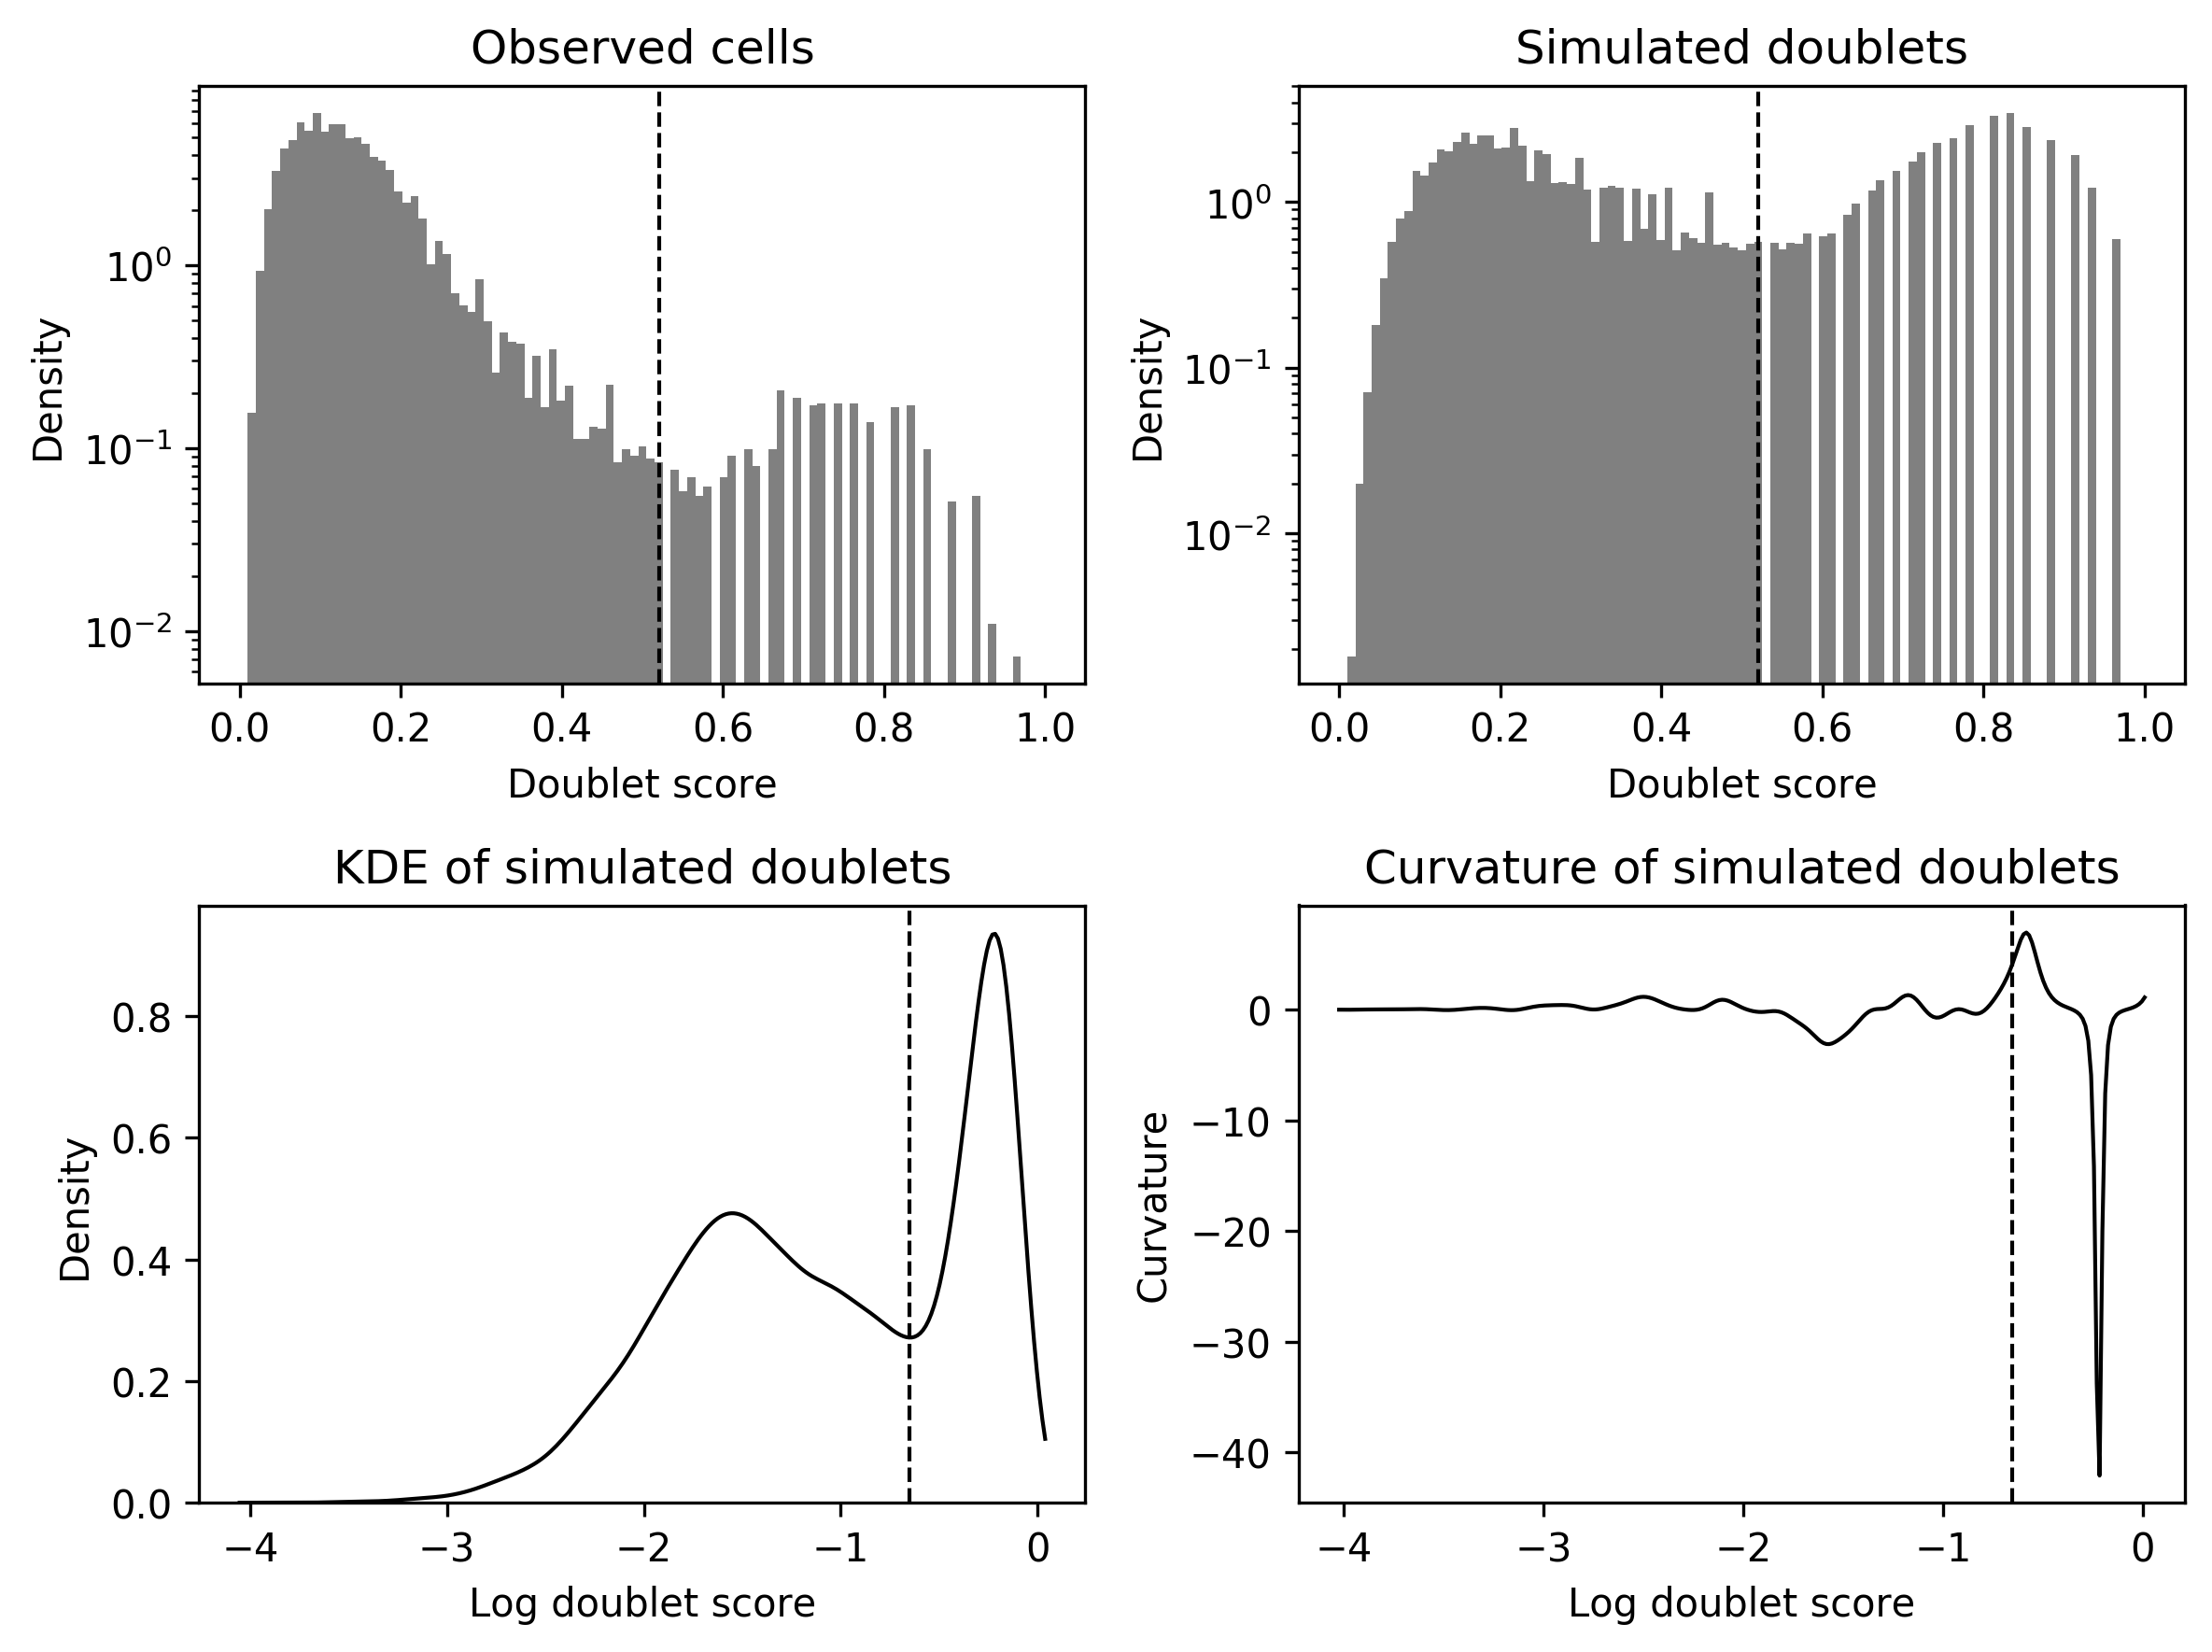

In [7]:
pg.infer_doublets(adata)
pg.mark_doublets(adata)

In [8]:
import collections, numpy
collections.Counter(adata.obs.pred_dbl)

Counter({False: 26474, True: 723})

In [9]:
tmp = clusters["cell.type"].to_dict()
celltype_dict = dict()
for k in tmp.keys():
    celltype_dict[k] = tmp[k]

In [10]:
for cl in range(0, max(adata.obs.louvain_labels) + 1):
    cl_subset = adata[adata.obs.louvain_labels == cl]
    cnt = collections.Counter(cl_subset.obs.demux_type)
    s = cnt["singlet"]
    d = cnt["doublet"]
    print("Cluster {}: {}; Cells - {}; Singlets - {}; Doublets - {}; Doublets%: {}%".format(cl, celltype_dict[cl], s + d, s, d, round(d * 100 / (s + d), 2)))

Cluster 0: Fibroblasts; Cells - 3217; Singlets - 3180; Doublets - 37; Doublets%: 1.15%
Cluster 1: Neurons; Cells - 2927; Singlets - 2920; Doublets - 7; Doublets%: 0.24%
Cluster 2: Unknown; Cells - 2688; Singlets - 2683; Doublets - 5; Doublets%: 0.19%
Cluster 3: Neural stem/precursor cells; Cells - 2293; Singlets - 2288; Doublets - 5; Doublets%: 0.22%
Cluster 4: Germ cells; Cells - 2146; Singlets - 2133; Doublets - 13; Doublets%: 0.61%
Cluster 5: Fibroblasts; Cells - 1871; Singlets - 1841; Doublets - 30; Doublets%: 1.6%
Cluster 6: Endothelial cells; Cells - 1673; Singlets - 1616; Doublets - 57; Doublets%: 3.41%
Cluster 7: Germ cells; Cells - 1511; Singlets - 1500; Doublets - 11; Doublets%: 0.73%
Cluster 8: Endothelial cells; Cells - 1167; Singlets - 1071; Doublets - 96; Doublets%: 8.23%
Cluster 9: Germ cells; Cells - 1123; Singlets - 1098; Doublets - 25; Doublets%: 2.23%
Cluster 10: Germ cells; Cells - 911; Singlets - 911; Doublets - 0; Doublets%: 0.0%
Cluster 11: Germ cells; Cells - 83

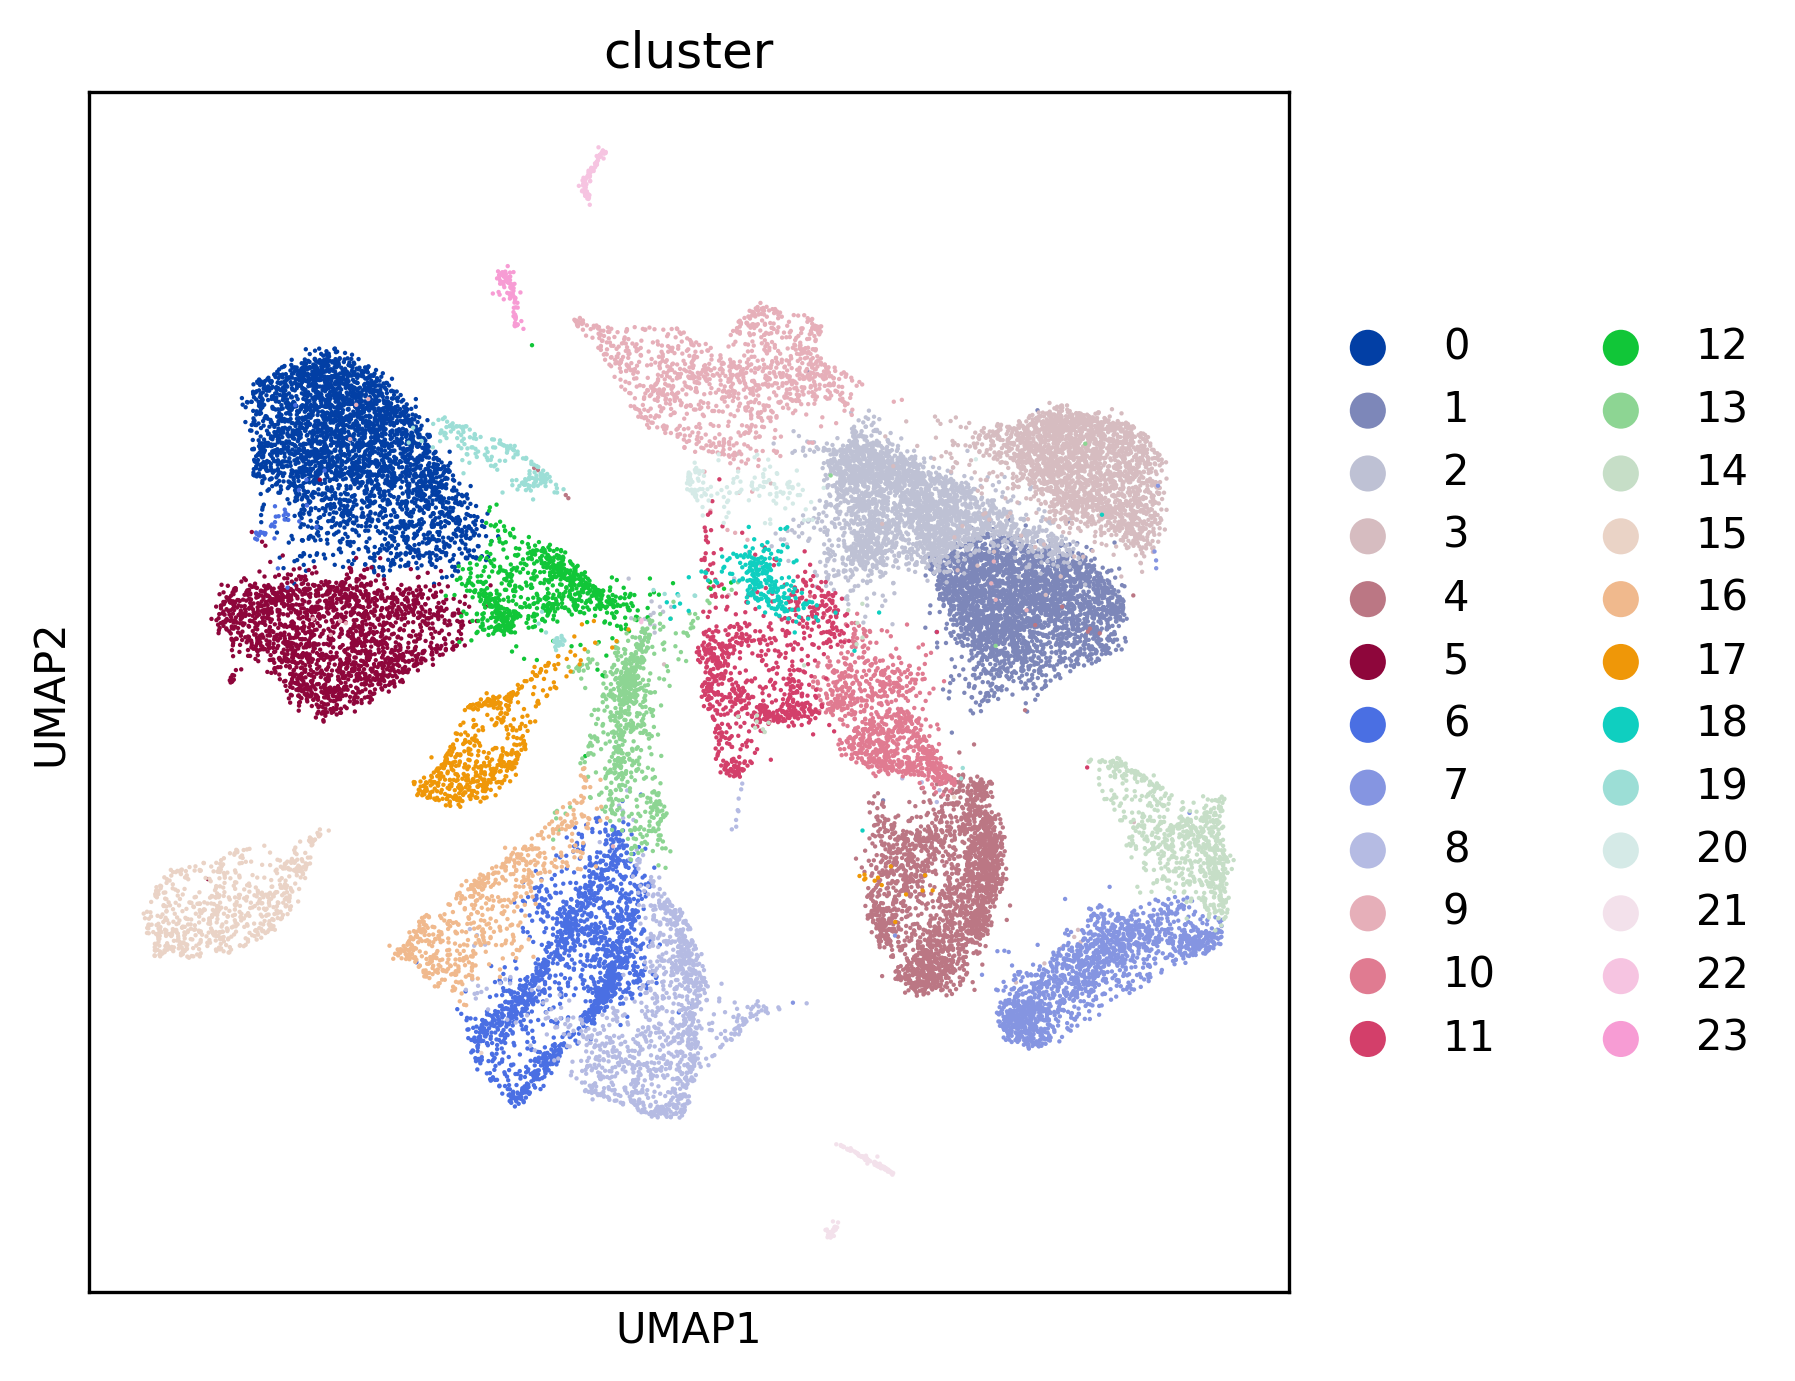

In [11]:
adata.obs["cluster"] = [str(t) for t in adata.obs.louvain_labels]
pg.scatter(adata, attrs="cluster", basis='umap')

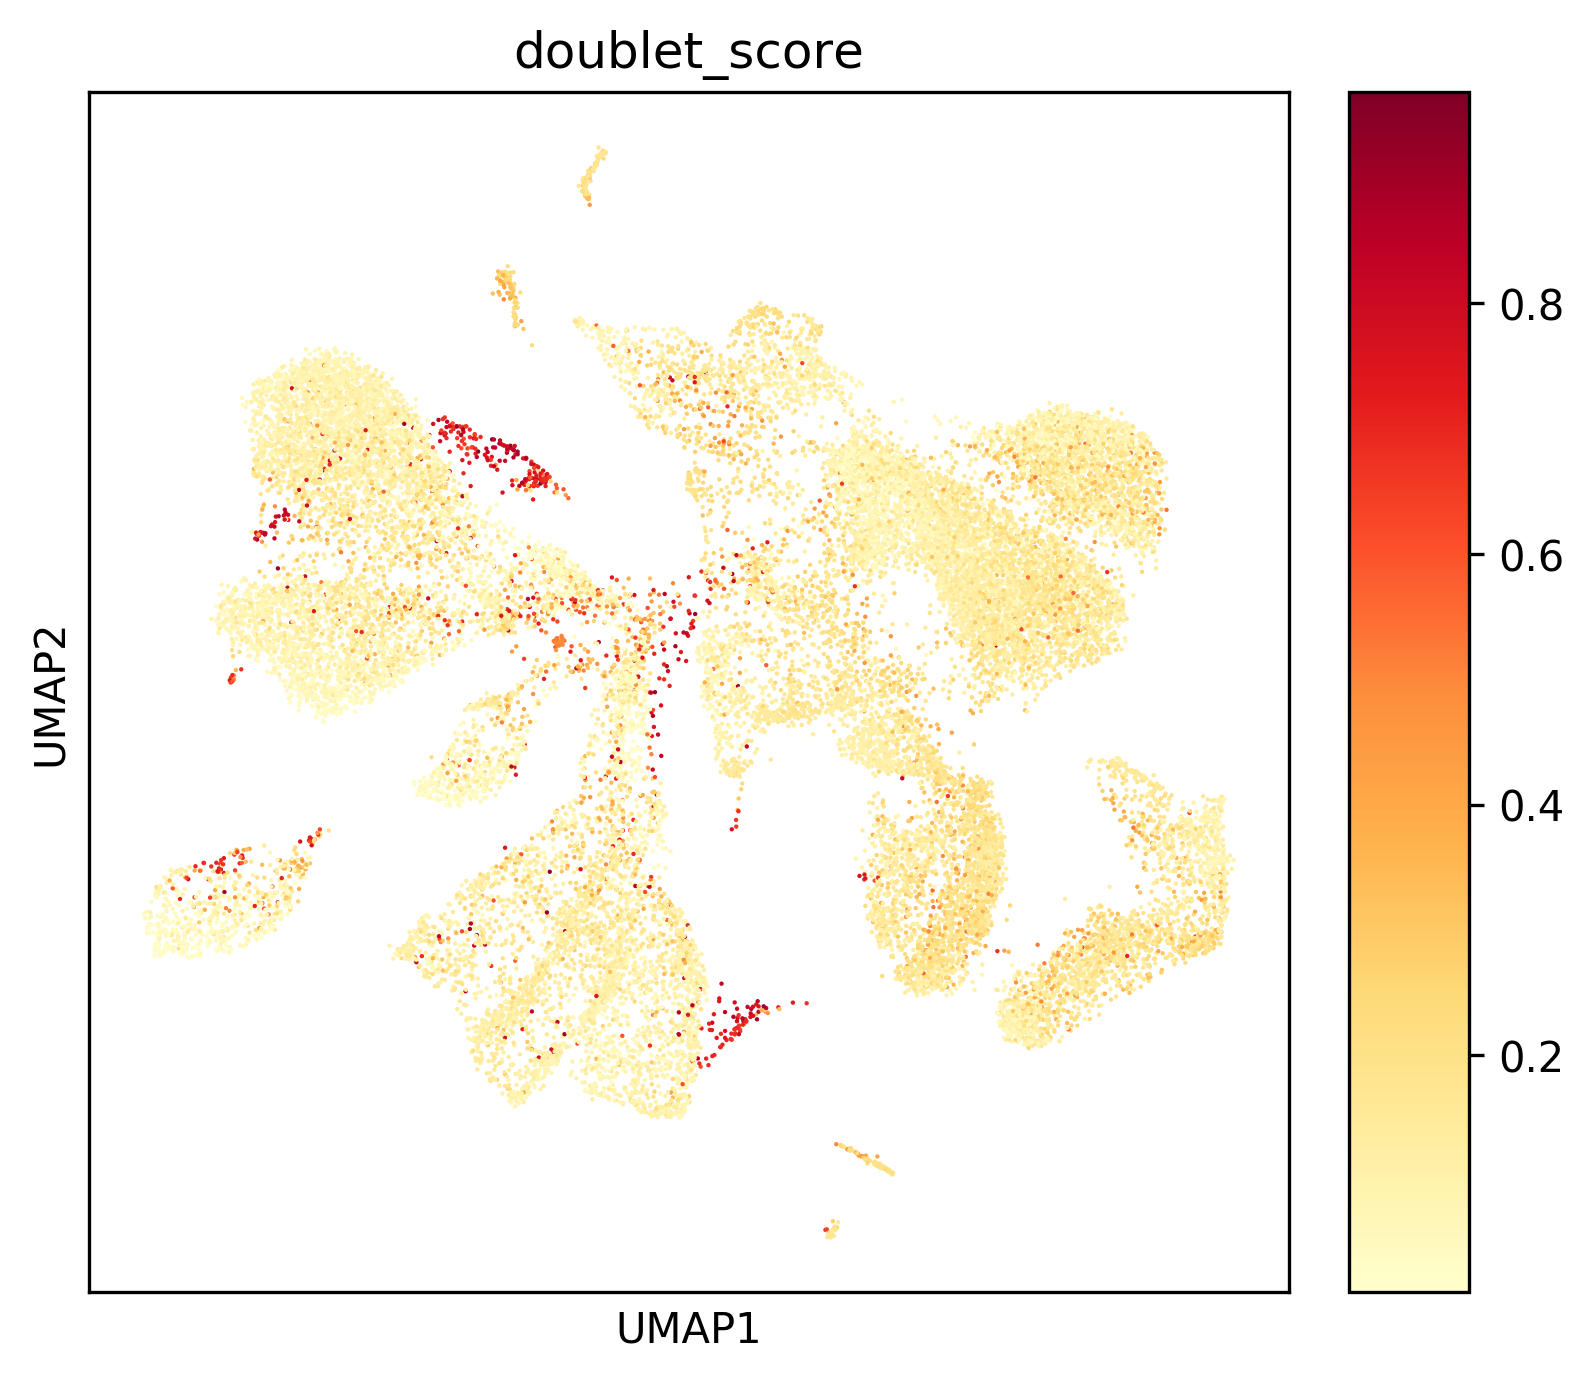

In [12]:
pg.scatter(adata, attrs="doublet_score", basis='umap')

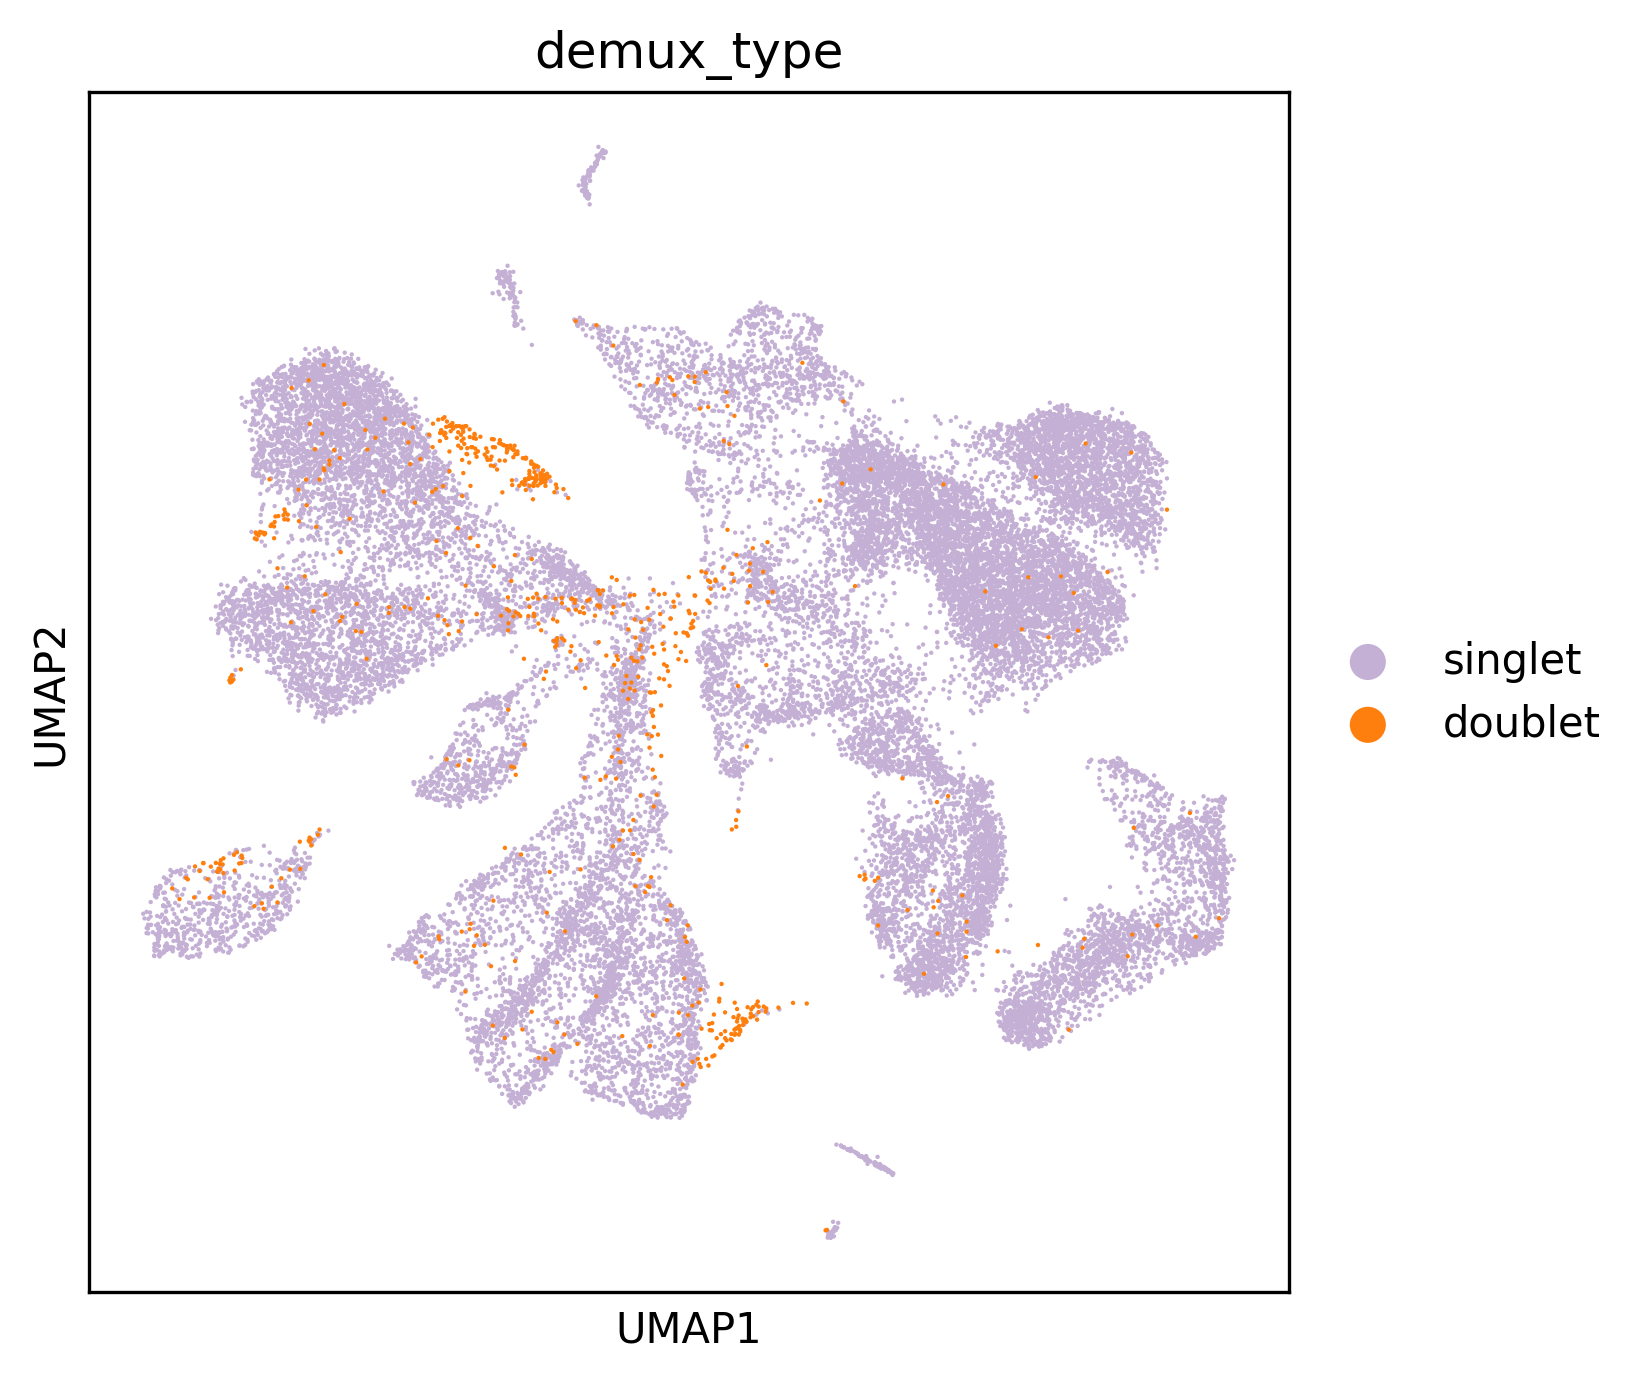

In [13]:
pg.scatter(adata, attrs="demux_type", basis='umap')

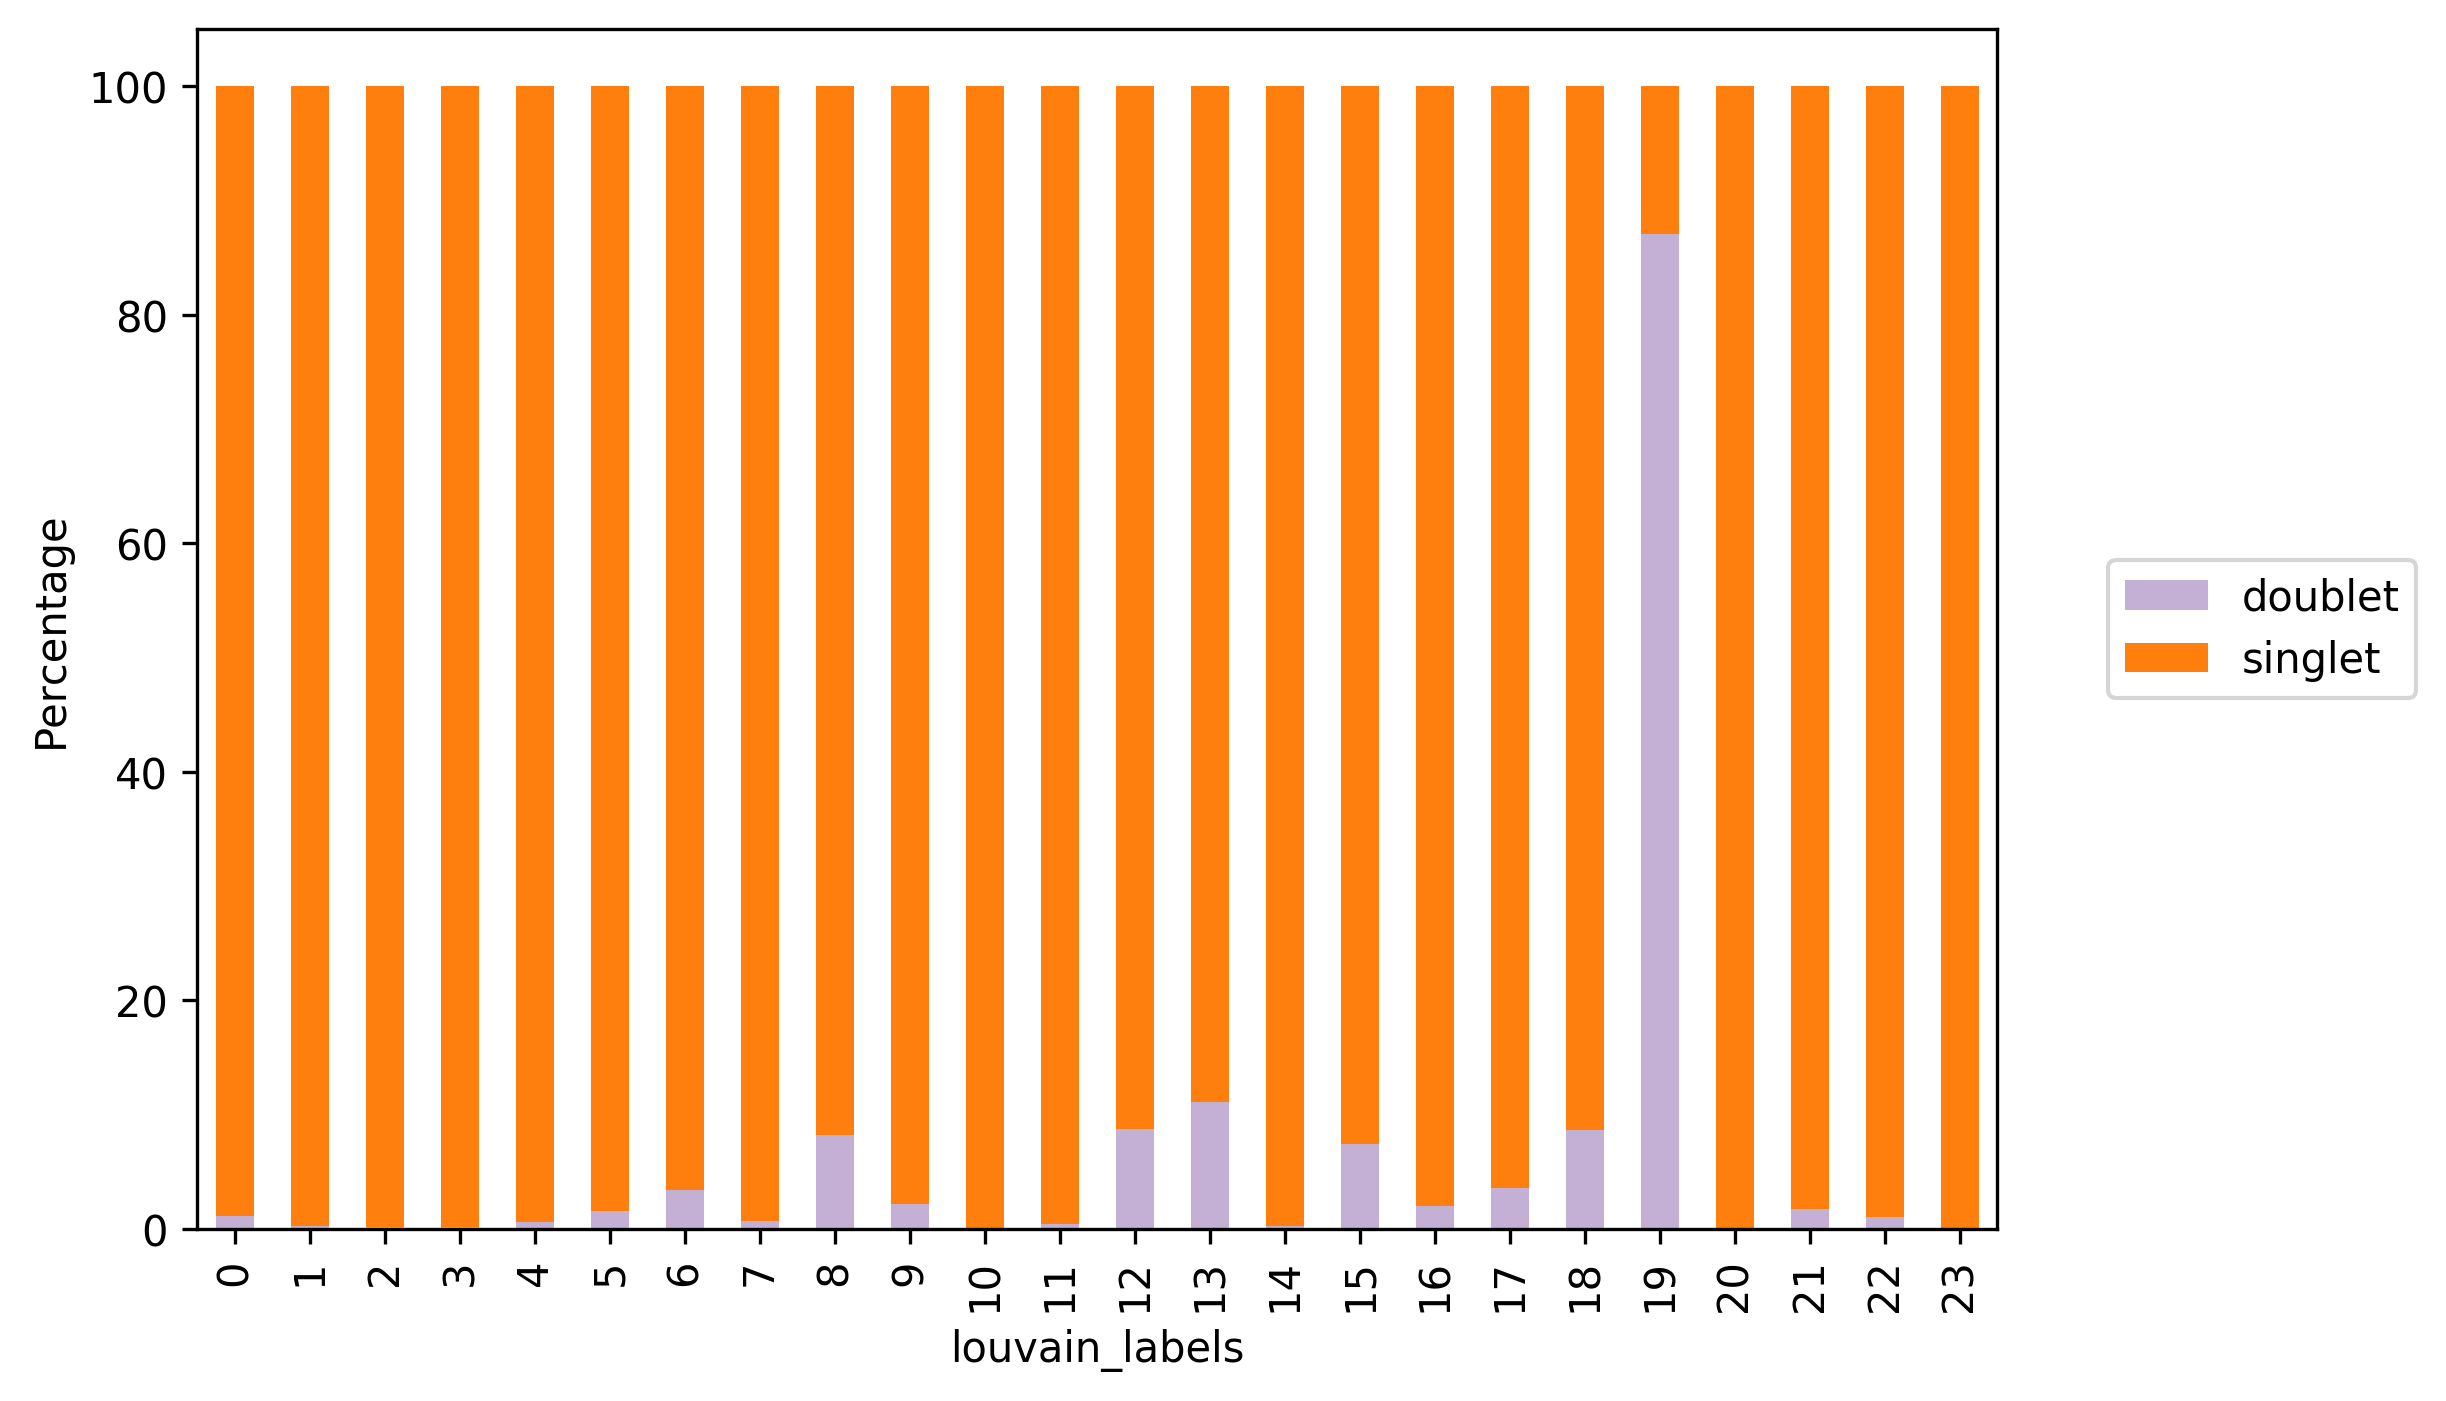

In [14]:
fig = pg.compo_plot(adata, 'louvain_labels', 'demux_type', style = 'frequency')

In [15]:
mad_only = adata[adata.obs.color == "MAD2 only"]

In [16]:
for cl in range(0, max(mad_only.obs.louvain_labels)):
    cl_subset = mad_only[mad_only.obs.louvain_labels == cl]
    if len(cl_subset.obs.Channel) == 0:
        continue
    cnt = collections.Counter(cl_subset.obs.demux_type)
    s = cnt["singlet"]
    d = cnt["doublet"]
    print("Cluster {}: {}; Cells - {}; Singlets - {}; Doublets - {}; Doublets%: {}%".format(cl, celltype_dict[cl], s + d, s, d, round(d * 100 / (s + d), 2)))

Cluster 0: Fibroblasts; Cells - 12; Singlets - 0; Doublets - 12; Doublets%: 100.0%
Cluster 1: Neurons; Cells - 2860; Singlets - 2853; Doublets - 7; Doublets%: 0.24%
Cluster 2: Unknown; Cells - 2607; Singlets - 2603; Doublets - 4; Doublets%: 0.15%
Cluster 3: Neural stem/precursor cells; Cells - 2189; Singlets - 2186; Doublets - 3; Doublets%: 0.14%
Cluster 4: Germ cells; Cells - 300; Singlets - 294; Doublets - 6; Doublets%: 2.0%
Cluster 5: Fibroblasts; Cells - 5; Singlets - 4; Doublets - 1; Doublets%: 20.0%
Cluster 6: Endothelial cells; Cells - 2; Singlets - 2; Doublets - 0; Doublets%: 0.0%
Cluster 7: Germ cells; Cells - 135; Singlets - 131; Doublets - 4; Doublets%: 2.96%
Cluster 8: Endothelial cells; Cells - 1; Singlets - 1; Doublets - 0; Doublets%: 0.0%
Cluster 9: Germ cells; Cells - 722; Singlets - 709; Doublets - 13; Doublets%: 1.8%
Cluster 10: Germ cells; Cells - 356; Singlets - 356; Doublets - 0; Doublets%: 0.0%
Cluster 11: Germ cells; Cells - 448; Singlets - 446; Doublets - 2; Dou

In [17]:
pg.annotate(adata, name='anno', based_on='louvain_labels', anno_dict=celltype_dict)

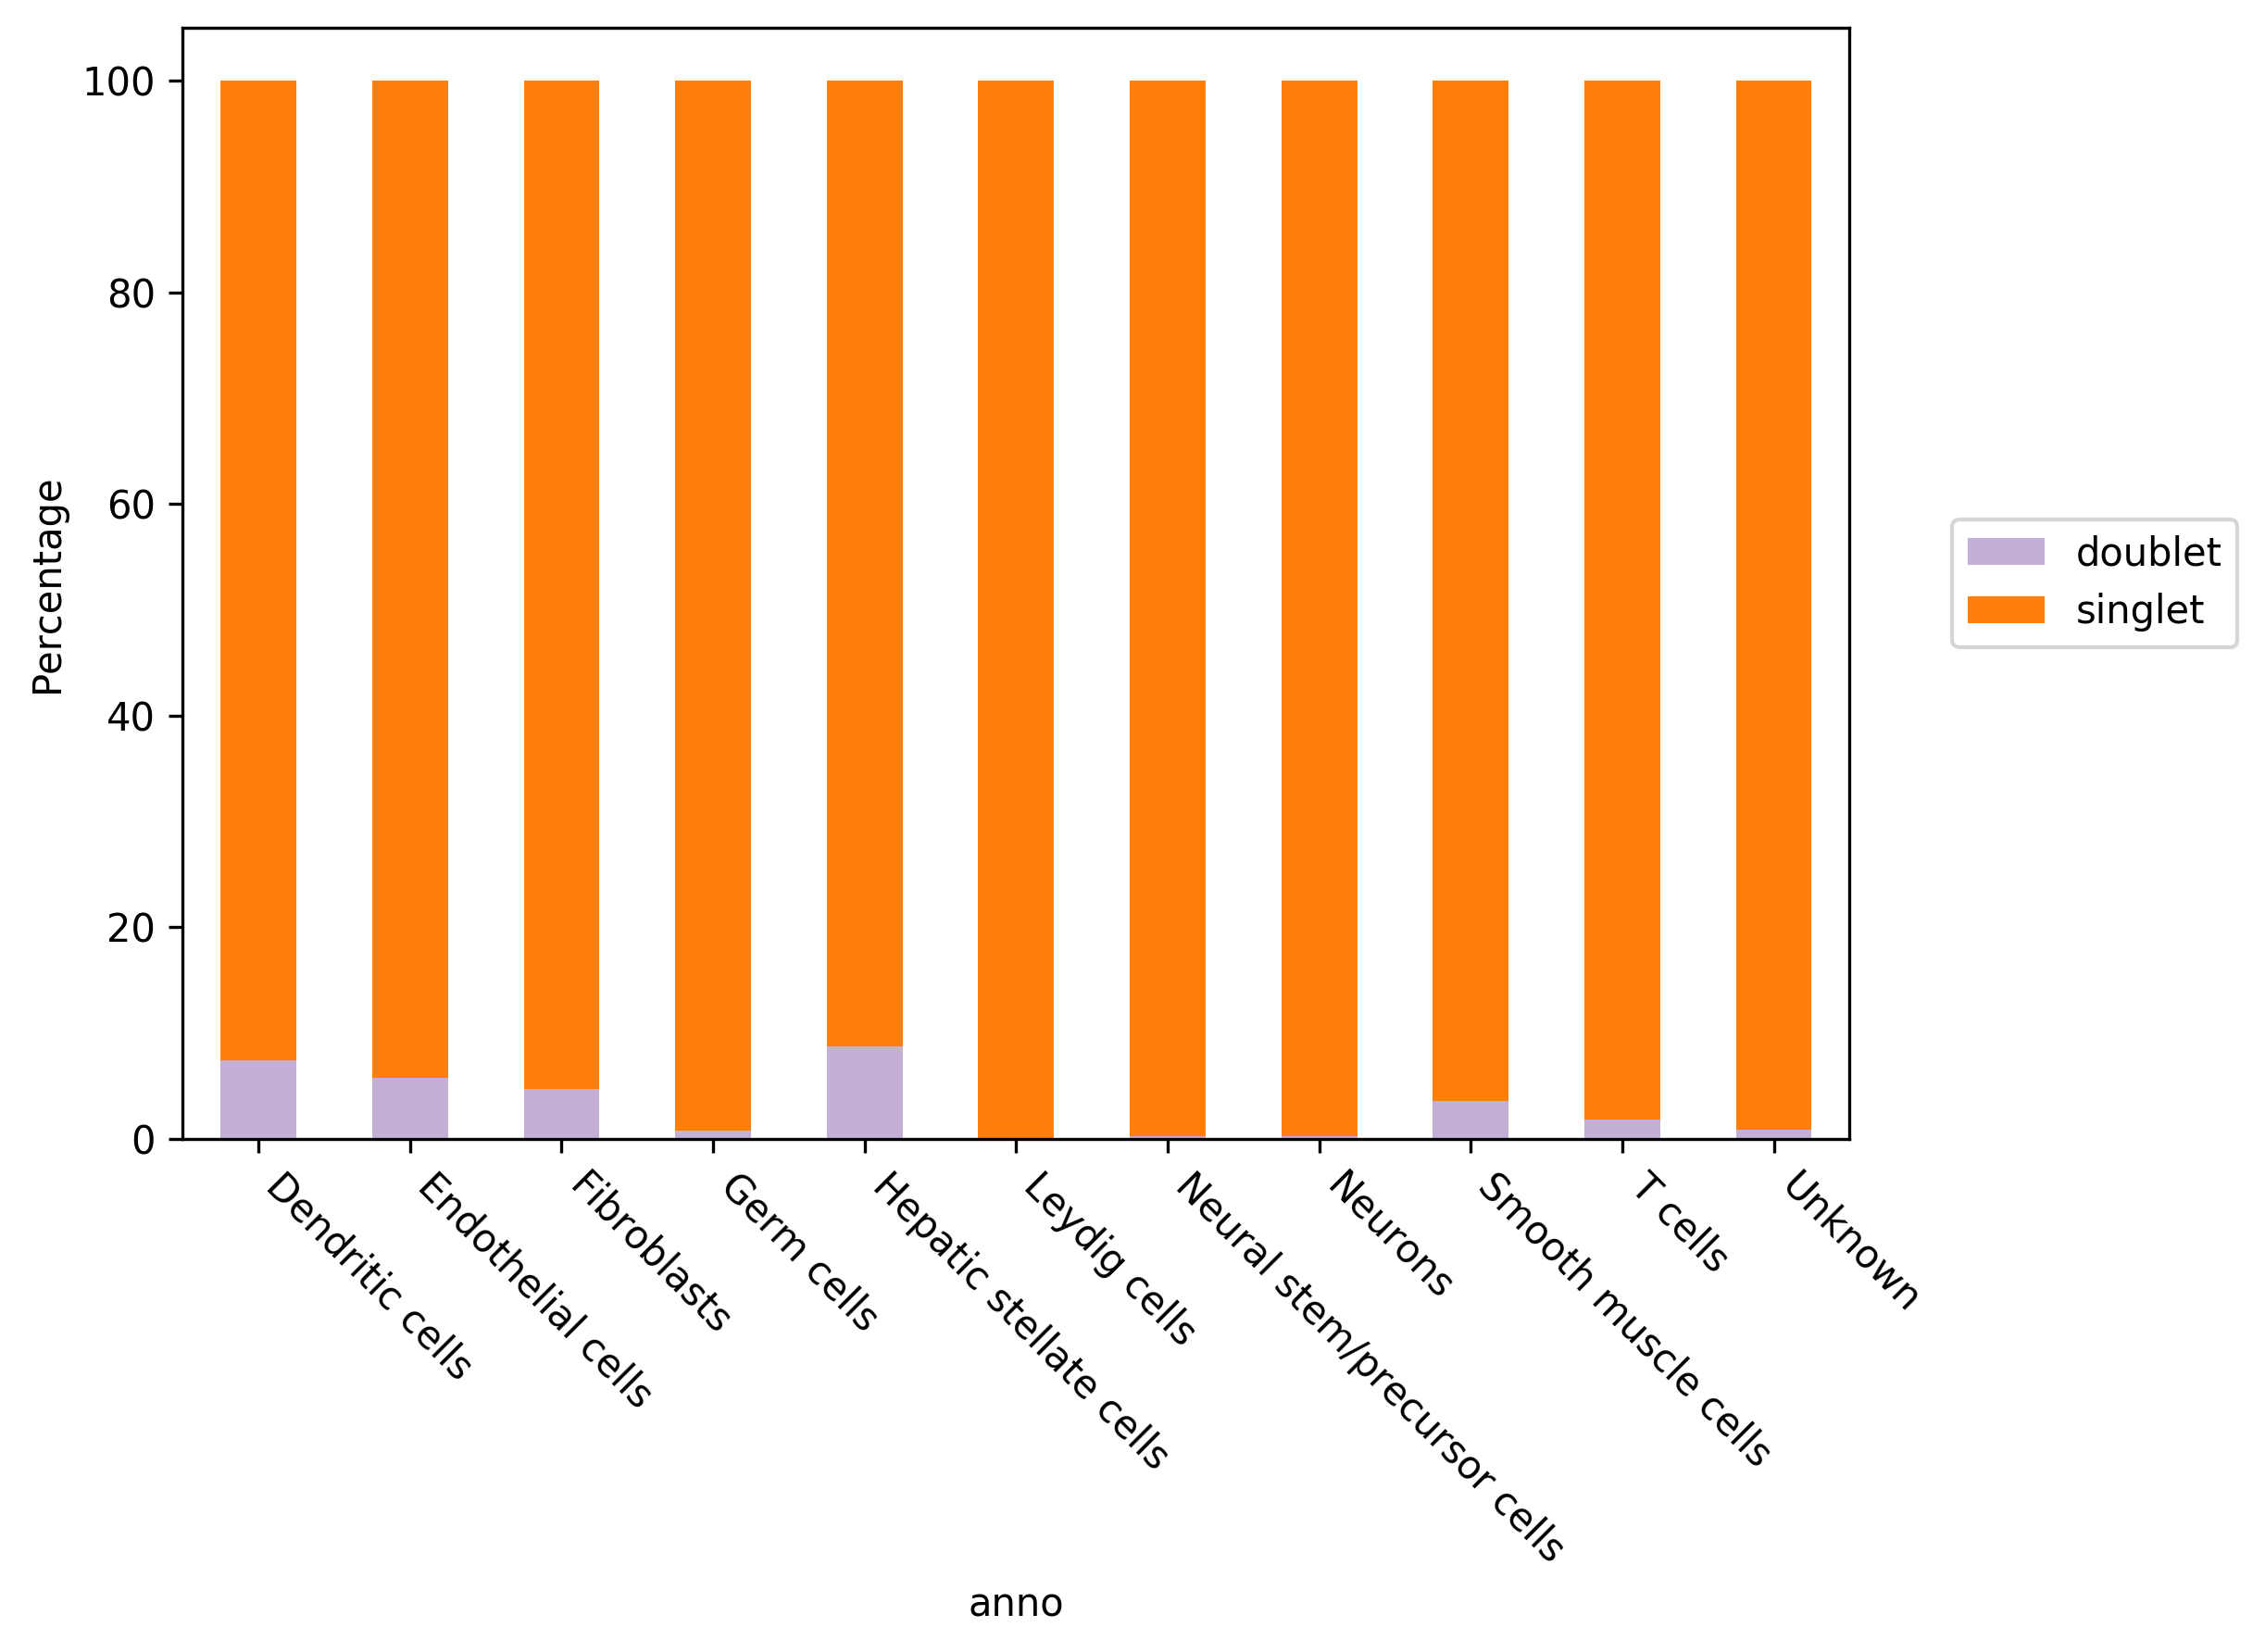

In [18]:
fig = pg.compo_plot(adata, 'anno', 'demux_type', style = 'frequency')

In [19]:
from math import log2

adata.obs["n_genes_log2"] = np.log2(adata.obs.n_genes)
adata_doublet = adata[(adata.obs.pred_dbl == True)]
adata_doublet[adata_doublet.obs.color == "MAD2 only"]

View of UnimodalData object with n_obs x n_vars = 190 x 48338
    Genome: GRCh38; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'Channel', 'annotations', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'is_mad2', 'color', 'louvain_labels', 'clusters', 'scale', 'doublet_score', 'pred_dbl', 'demux_type', 'cluster', 'anno', 'n_genes_log2'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_umap'
    varm: 
    uns: 'genome', 'modality'

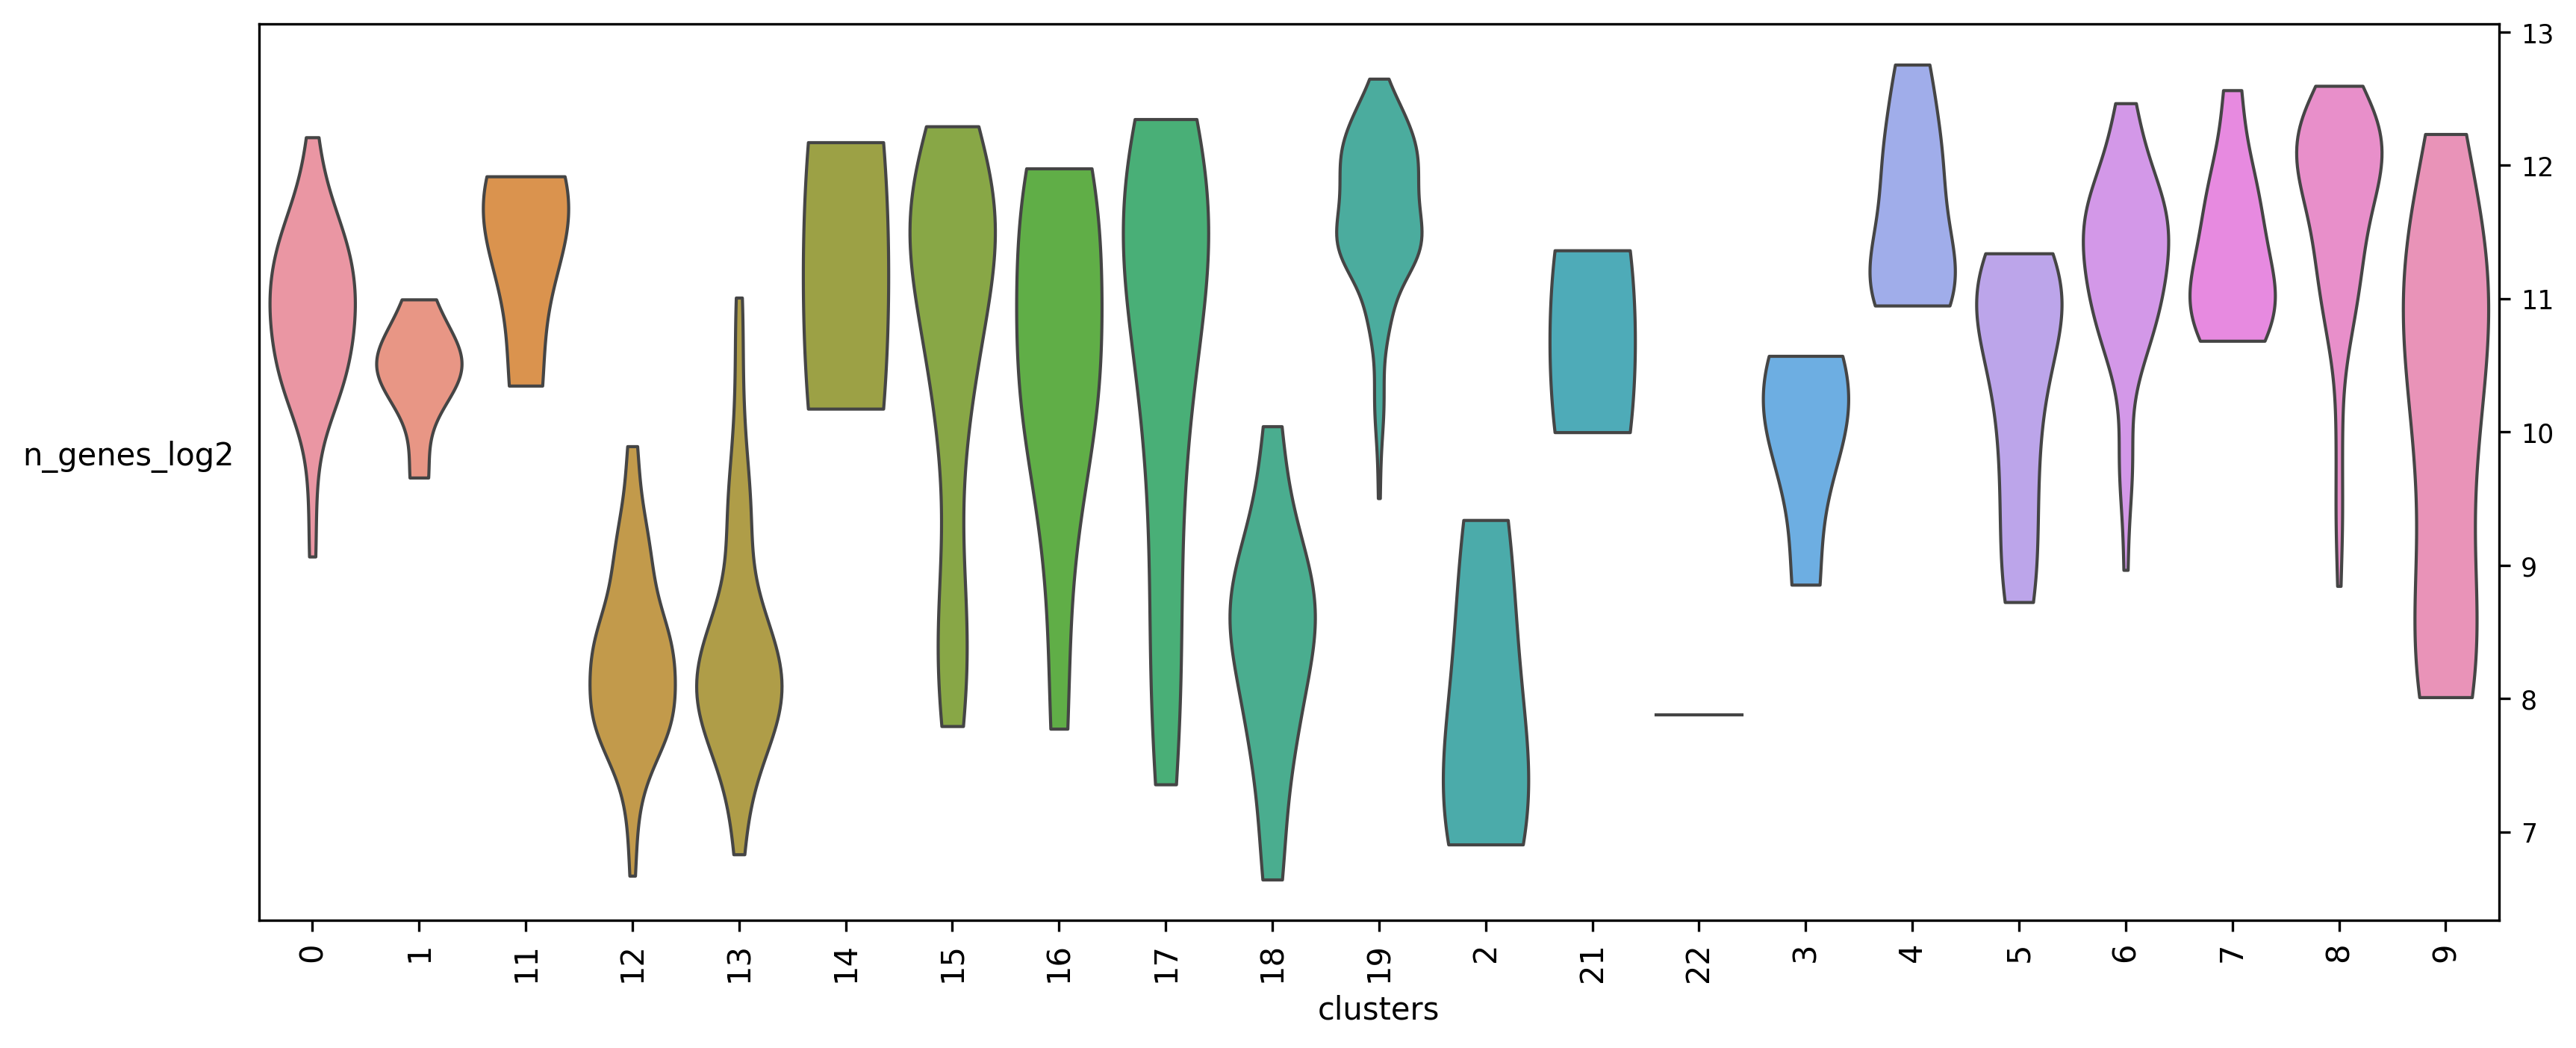

In [20]:
pg.violin(adata_doublet, attrs="n_genes_log2", groupby='clusters', panel_size=(10, 4))

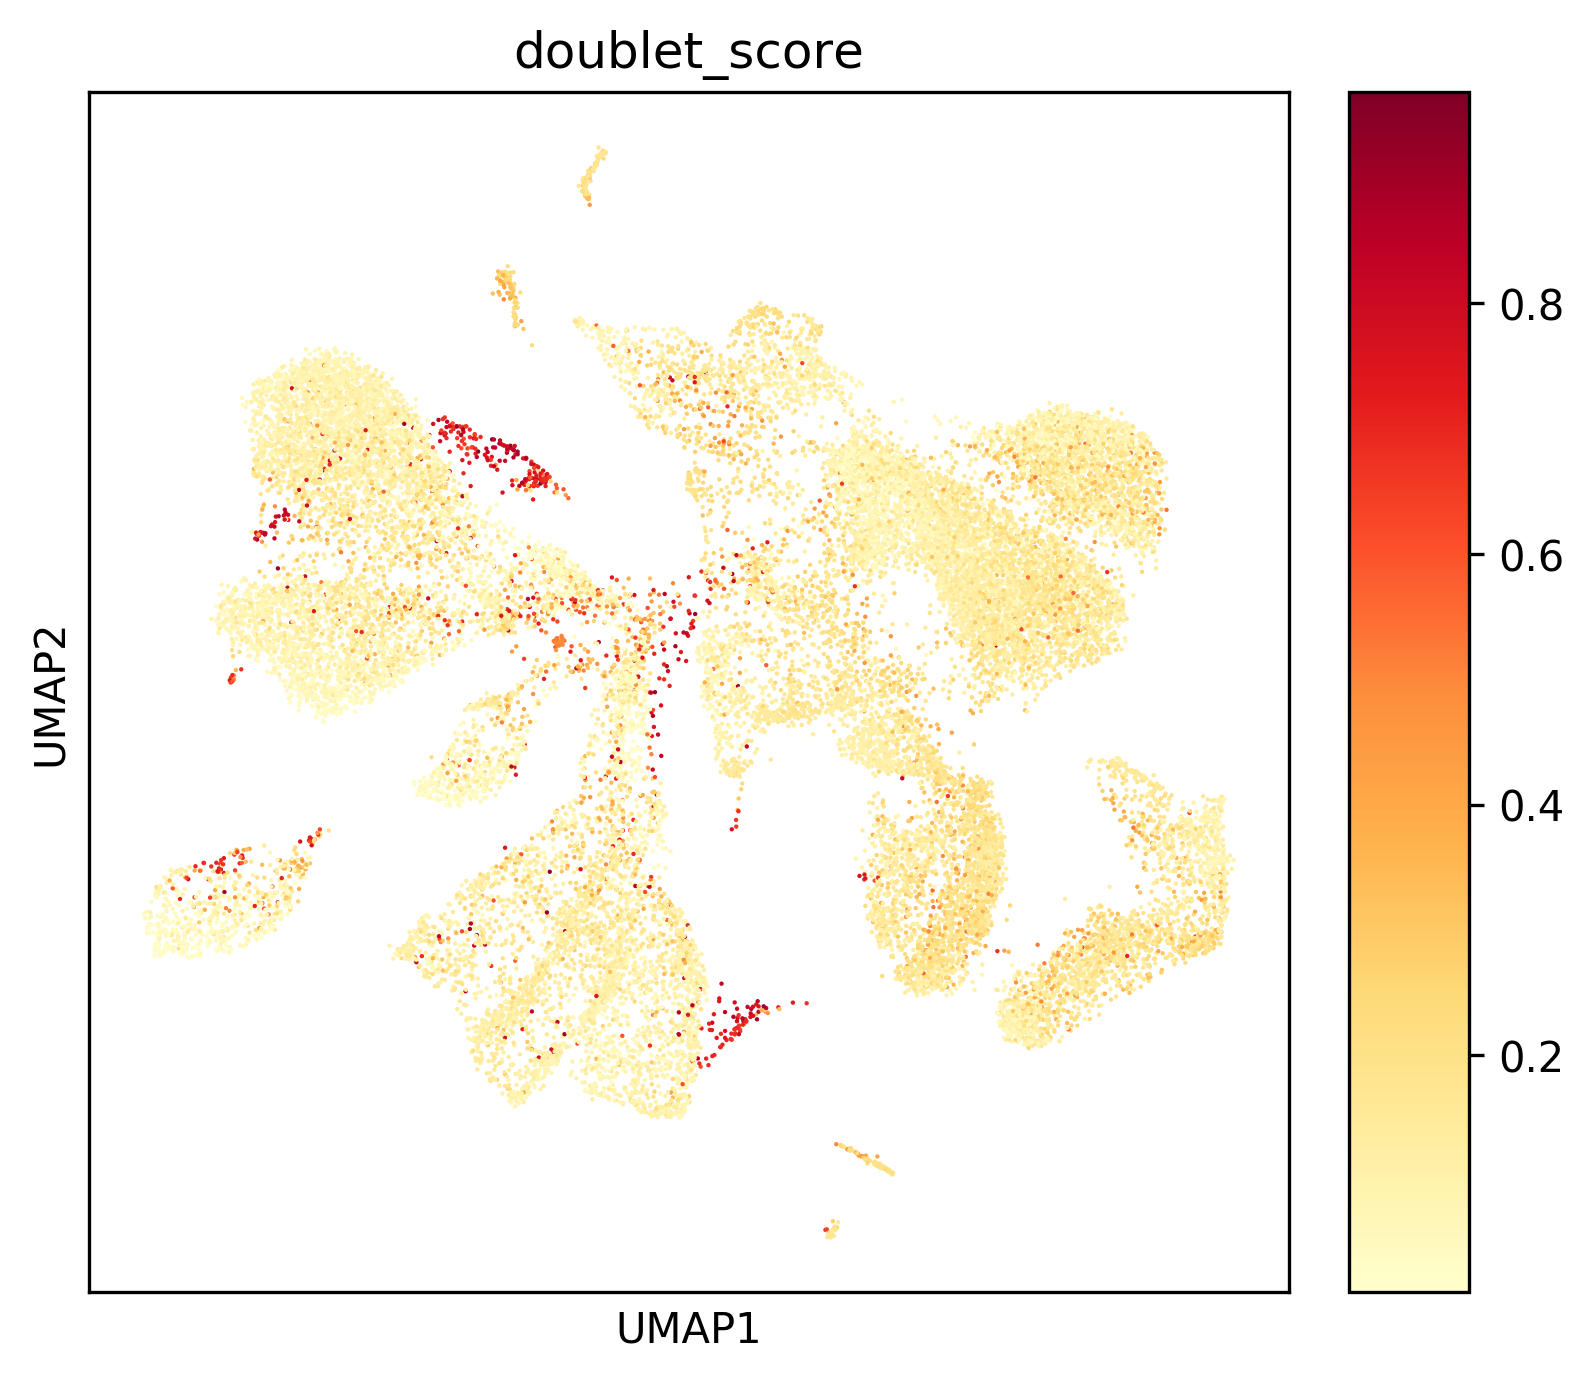

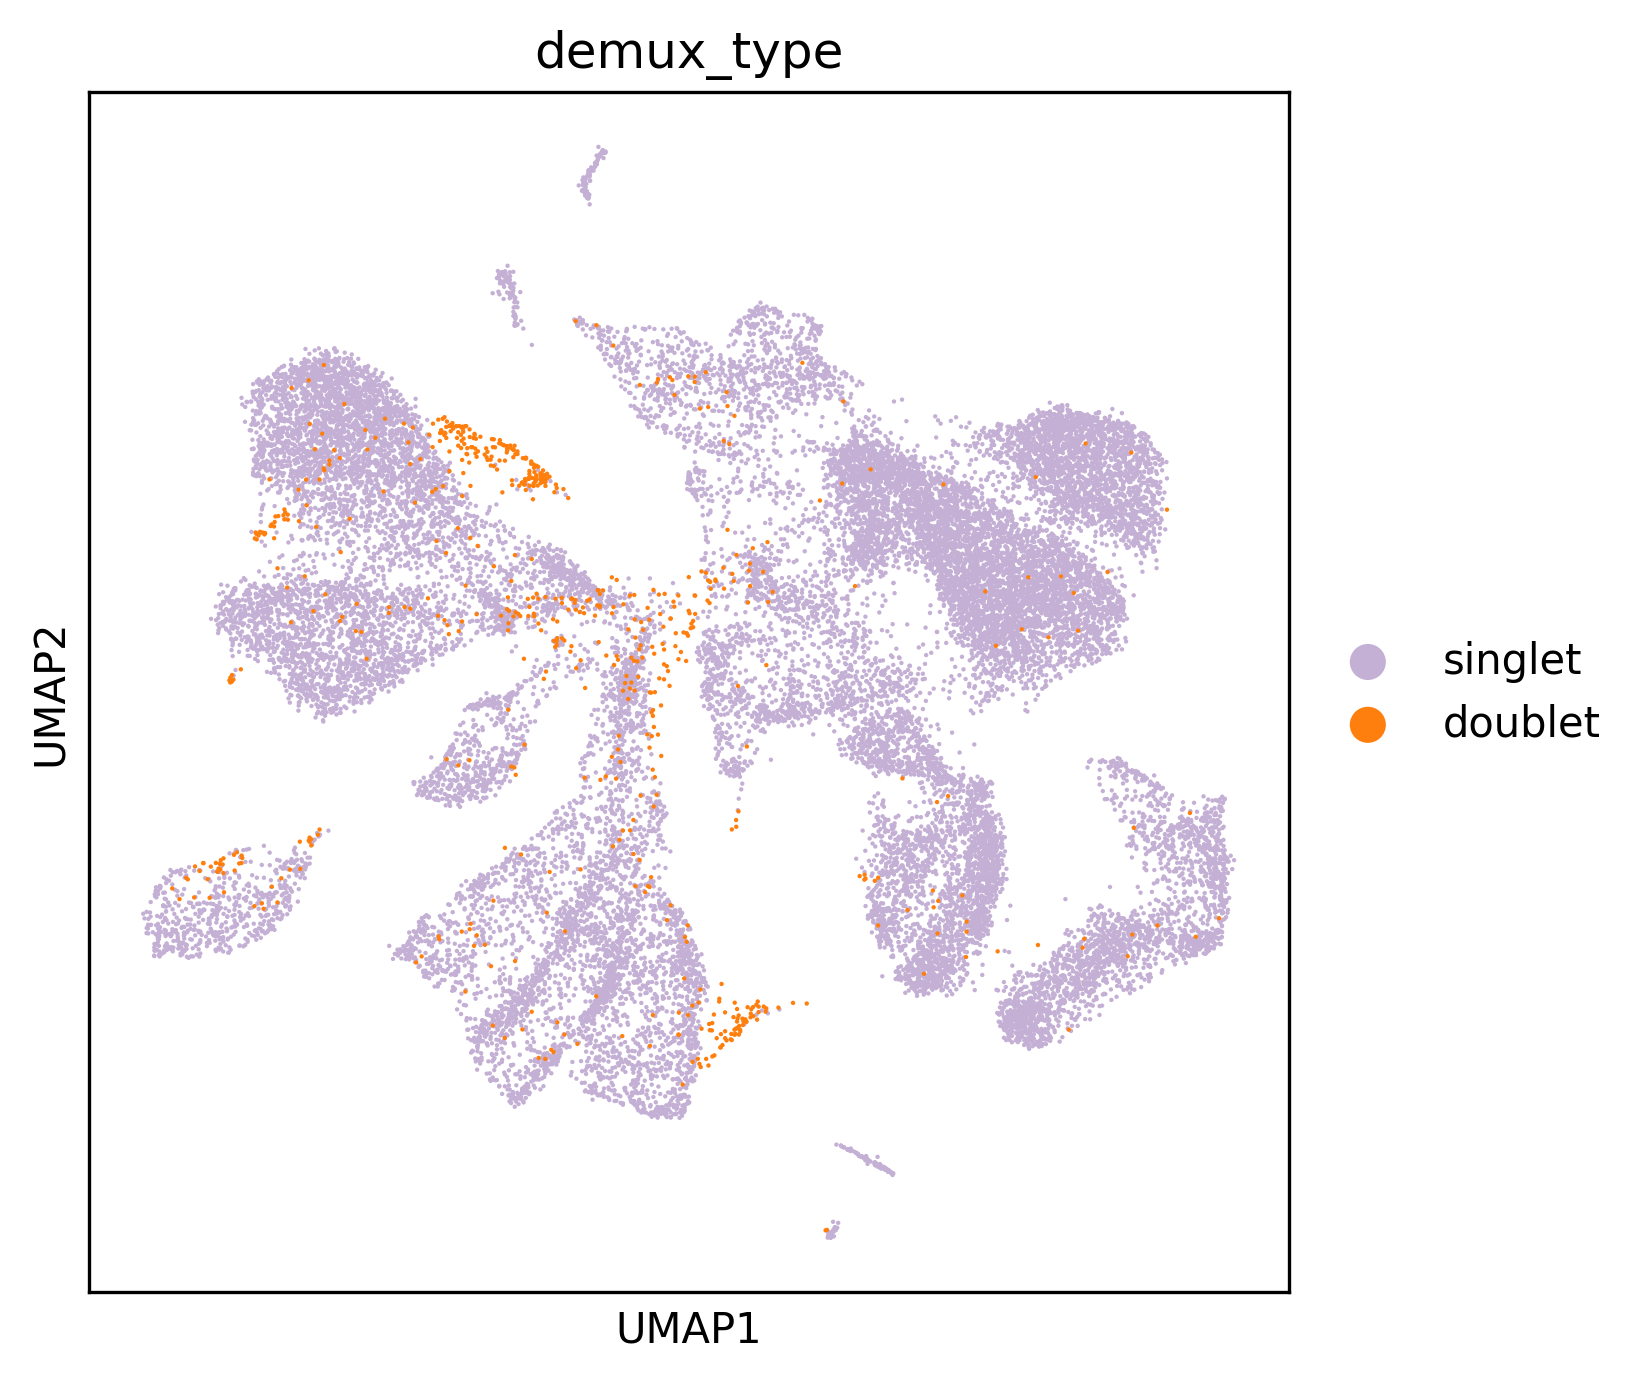

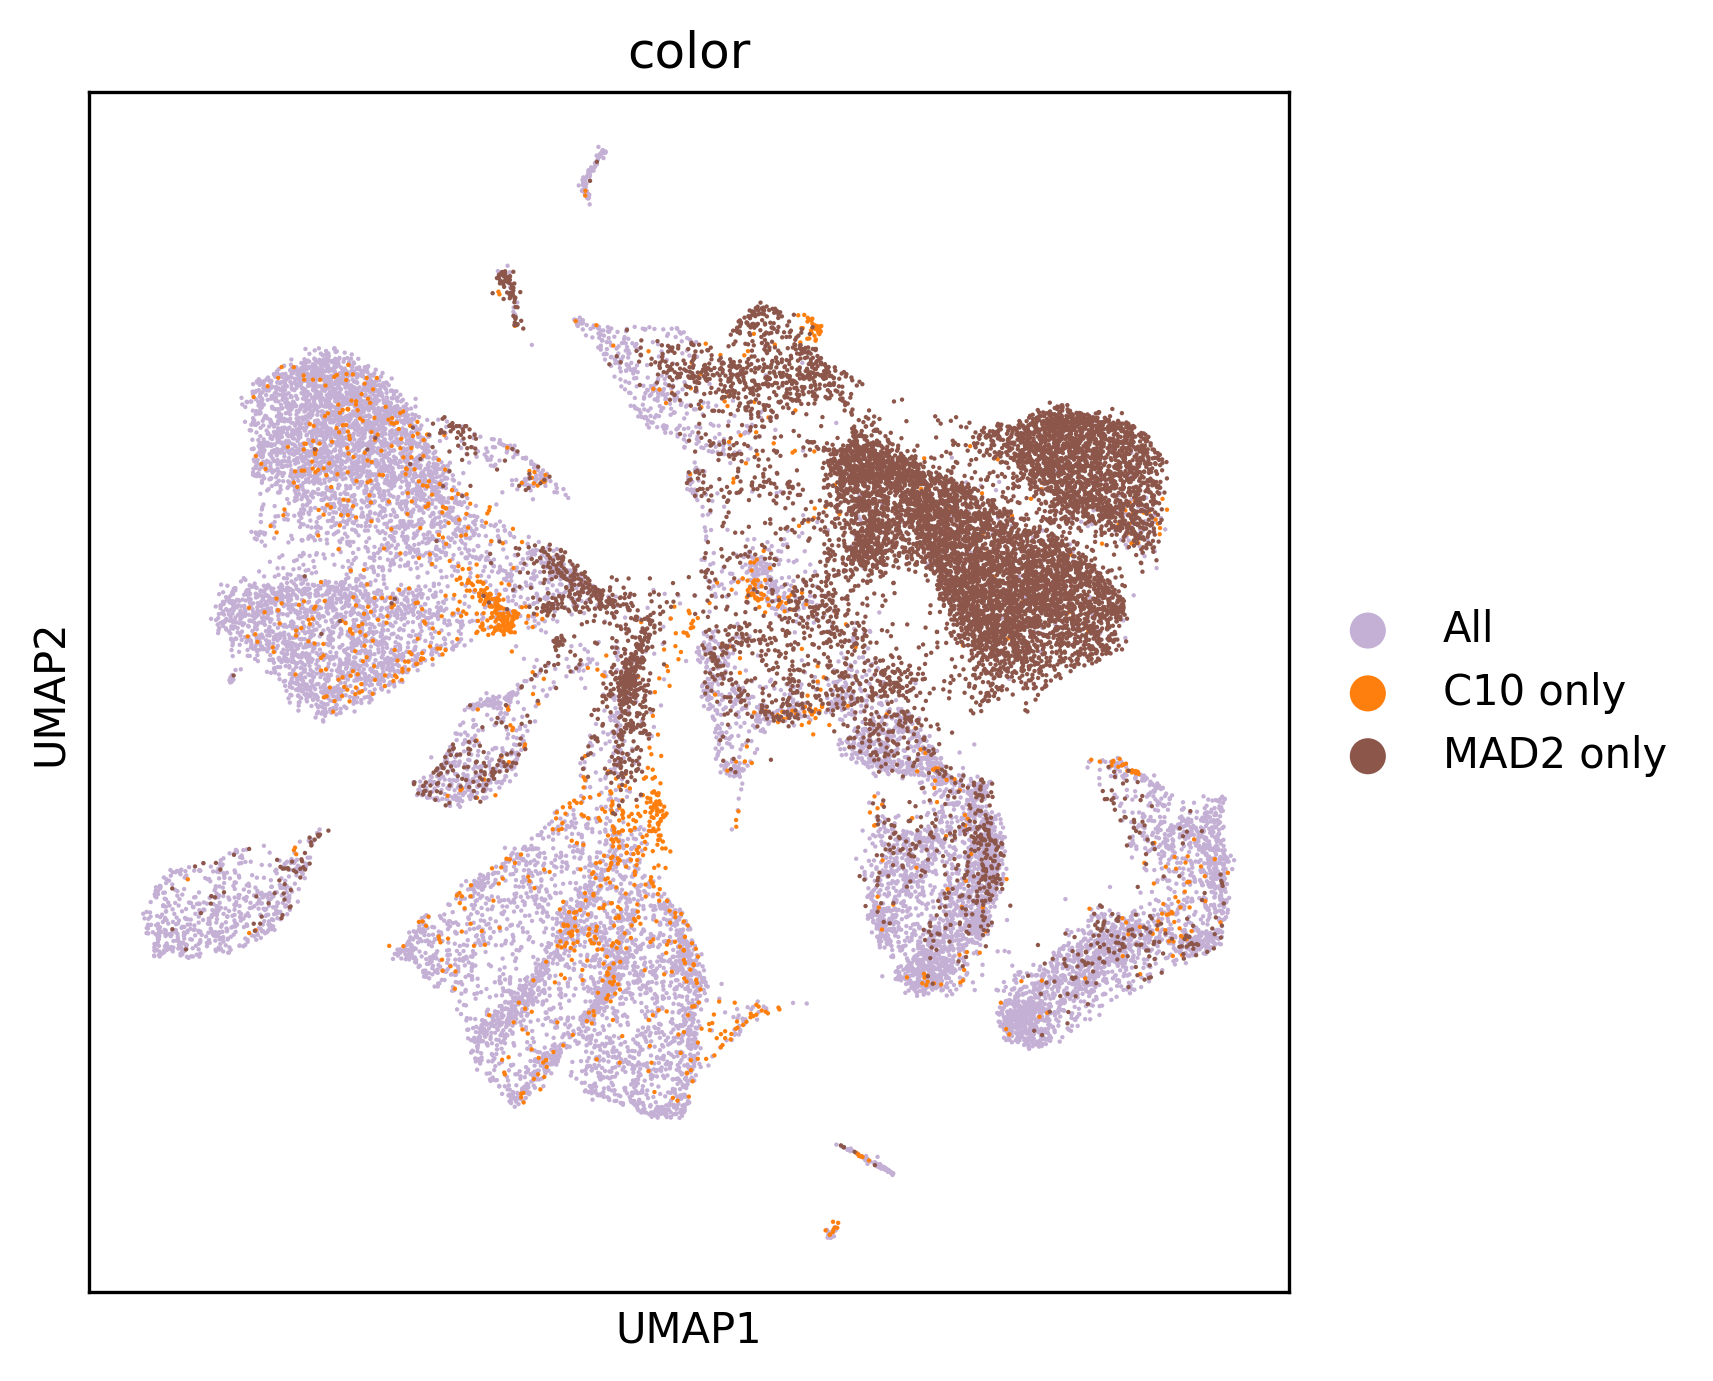

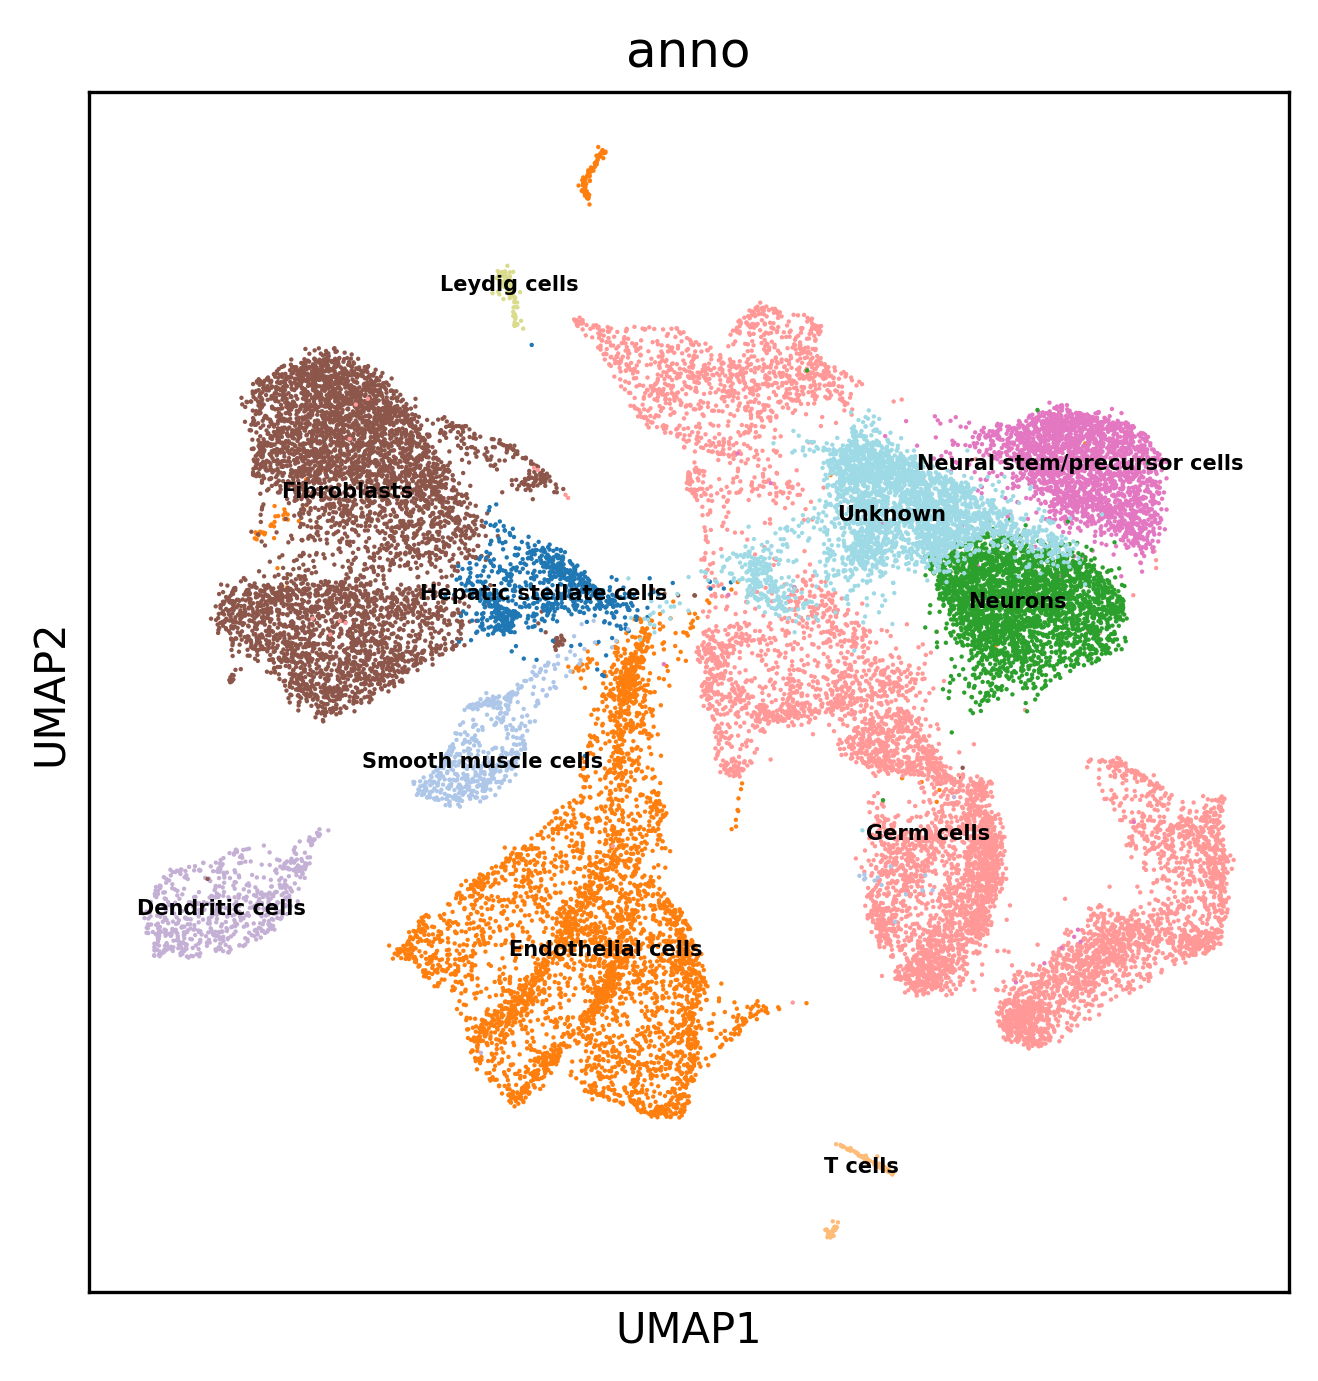

In [21]:
pg.scatter(adata, attrs="doublet_score", basis='umap')
pg.scatter(adata, attrs="demux_type", basis='umap')
pg.scatter(adata, attrs="color", basis='umap')
pg.scatter(adata, attrs="anno", basis='umap', legend_loc='on data')